In [2]:
import pandas as pd
from IPython.display import SVG, display
import svgpathtools as pt
import numpy as np
import re
import json
import shutil

This is exactly the same as the original `clickable_map`, but it works on an SVG file which was generated by the former notebook and then manually corrected

In [1]:
inputmap = 'editable_map_test_3.svg'

In [3]:
viewBox = pt.Document(inputmap).root.attrib['viewBox']

In [4]:
style = '''
<xsl:stylesheet version="1.0" xmlns:xsl="http://www.w3.org/1999/XSL/Transform" xmlns:svg="http://www.w3.org/2000/svg">
    
    <xsl:output method="xml"/>
    
    <xsl:template match="/">
        <groups>
            <xsl:apply-templates select="/svg:svg/svg:g[@id='frontier']/svg:path" />
        </groups>
    </xsl:template>

    <!-- indices to merge references -->
    <xsl:template match="svg:path">
        <frontier>
            <d><xsl:value-of select="@d" /></d>
            <id><xsl:value-of select="../@id" /></id>
        </frontier>
    </xsl:template>
    
</xsl:stylesheet>
'''
frontier = pd.read_xml(inputmap, stylesheet=style, xpath='/groups/*',)
frontier['path'] = frontier['d'].apply(lambda r: pt.parse_path(r).d())

Next, the actual meet: the paths and lines representing buslines. We'll convert lines t o paths for a more homogenous representation and generally apply `svgpathtools.Path` to retain only absolute coordinates (I did not find out how to effectively use `svgpathtools` own eltree based methods to parse SVG directly):

In [12]:
def split_id_code(dta):
    codes = dta['id'].str.extract('\w+-([0-9]+)(?:-\w+)?')
    dta['id'] = codes[0].astype(int)
    return dta


In [18]:
style = '''
<xsl:stylesheet version="1.0" xmlns:xsl="http://www.w3.org/1999/XSL/Transform" xmlns:svg="http://www.w3.org/2000/svg">
    
    <xsl:output method="xml"/>
    
    <xsl:template match="/">
        <groups>
            <xsl:apply-templates select="/svg:svg/svg:g[@id='lines']/svg:g//svg:line" />
            <xsl:apply-templates select="/svg:svg/svg:g[@id='lines']/svg:g//svg:polyline" />
            <xsl:apply-templates select="/svg:svg/svg:g[@id='lines']/svg:g//svg:polygon" />
            <xsl:apply-templates select="/svg:svg/svg:g[@id='lines']/svg:g//svg:path" />
        </groups>
    </xsl:template>

    <!-- indices to merge references -->
    <xsl:template match="svg:polyline">
        <ligne>
            <points><xsl:value-of select="@points" /></points>
            <id><xsl:value-of select="ancestor::svg:g[@id!='lines']/@id" /></id>
            <class><xsl:value-of select="@class" /></class>
        </ligne>
    </xsl:template>
    
    <xsl:template match="svg:polygon">
        <ligne>
            <points><xsl:value-of select="@points" /></points>
            <id><xsl:value-of select="ancestor::svg:g[@id!='lines']/@id" /></id>
            <class><xsl:value-of select="@class" /></class>
        </ligne>
    </xsl:template>
    
    <xsl:template match="svg:line">
        <ligne>
            <d>M <xsl:value-of select="@x1" />,<xsl:value-of select="@y1" /> L <xsl:value-of select="@x2" />,<xsl:value-of select="@y2" /></d>
            <id><xsl:value-of select="ancestor::svg:g[@id!='lines']/@id" /></id>
            <class><xsl:value-of select="@class" /></class>
        </ligne>
    </xsl:template>
    
    <xsl:template match="svg:path">
        <ligne>
            <d><xsl:value-of select="@d" /></d>
            <id><xsl:value-of select="ancestor::svg:g[@id!='lines']/@id" /></id>
            <class><xsl:value-of select="@class" /></class>
        </ligne>
    </xsl:template>

    
</xsl:stylesheet>
'''
lines = pd.read_xml(inputmap, stylesheet=style, xpath='/groups/*')

lines = split_id_code(lines)

def iter_sequence_as_pairs(it):
    prev = None
    for i, cur in enumerate(it):
        if i % 2 == 1:
            yield (prev, cur)
        prev = cur
        

# transform everything to paths
filt = ~lines['d'].isnull()
lines.loc[filt, 'path'] = lines.loc[filt, 'd'].apply(lambda d: pt.parse_path(d).d())
#filt = ~lines['points'].isnull()
#lines.loc[filt, 'path'] = lines.loc[filt, 'points'].apply(lambda d: pt.polyline(*(a + b * 1j for a, b in iter_sequence_as_pairs((float(s) for s in d.split(' '))))).d())
#lines = lines.drop(['points', 'd'], axis=1)
lines = lines.drop(['d'], axis=1)

# actually, it turns out not to be useful to retain class
lines = lines.drop_duplicates(['id', 'path'])
lines = lines.drop('class', axis=1)

Next we have a bunch of circles representings stops and locations. 

In [19]:
style = '''
<xsl:stylesheet version="1.0" xmlns:xsl="http://www.w3.org/1999/XSL/Transform" xmlns:svg="http://www.w3.org/2000/svg">
    
    <xsl:output method="xml"/>
    
    <xsl:template match="/">
        <groups>
            <xsl:apply-templates select="/svg:svg/svg:g[@id='stops']//svg:circle" />
            <xsl:apply-templates select="/svg:svg/svg:g[@id='stops']//svg:path" />
            <xsl:apply-templates select="/svg:svg/svg:g[@id='stops']//svg:ellipse" />
        </groups>
    </xsl:template>

    <xsl:template match="svg:path">
        <ligne>
            <id><xsl:value-of select="ancestor::svg:g[@id!='stops']/@id" /></id>
            <d><xsl:value-of select="@d" /></d>
            <class><xsl:value-of select="@class" /></class>
        </ligne>
    </xsl:template>

    <xsl:template match="svg:circle">
        <stop>
            <id><xsl:value-of select="ancestor::svg:g[@id!='stops']/@id" /></id>
            <cx><xsl:value-of select="@cx" /></cx>
            <cy><xsl:value-of select="@cy" /></cy>
            <rx><xsl:value-of select="@r" /></rx>
            <class><xsl:value-of select="@class" /></class>
            <transform><xsl:value-of select="@transform" /></transform>
        </stop>
    </xsl:template>

    <xsl:template match="svg:ellipse">
        <stop>
            <id><xsl:value-of select="ancestor::svg:g[@id!='stops']/@id" /></id>
            <cx><xsl:value-of select="@cx" /></cx>
            <cy><xsl:value-of select="@cy" /></cy>
            <rx><xsl:value-of select="@rx" /></rx>
            <ry><xsl:value-of select="@ry" /></ry>
            <class><xsl:value-of select="@class" /></class>
            <transform><xsl:value-of select="@transform" /></transform>
        </stop>
    </xsl:template>

    
</xsl:stylesheet>
'''
stop_places = pd.read_xml(inputmap, stylesheet=style, xpath='/groups/*')

stop_places = split_id_code(stop_places)

# convert to path - store coordinates of bbox's center as 'cx' and 'cy'
filt = ~stop_places['d'].isnull()
paths = stop_places.loc[filt, 'd'].apply(lambda d: pt.parse_path(d))
stop_places.loc[filt, 'path'] = paths.apply(lambda d: d.d())
stop_places.loc[filt, 'cx'] = paths.apply(lambda d: np.mean(d.bbox()[:2]))
stop_places.loc[filt, 'cy'] = paths.apply(lambda d: np.mean(d.bbox()[3:]))


# extract translate and rotate instructions
pos = stop_places['transform'].str.extract('translate\((-?\d+(?:\.\d+)?) *,? (-?\d+(?:\.\d+)?)\)')
stop_places['translate_x'] = pos[0]
stop_places['translate_y'] = pos[1]
stop_places['rotate'] = stop_places['transform'].str.extract('rotate\( *(-?\d+(?:\.\d+)?) *\)')[0]
stop_places = stop_places.drop('transform', axis=1)
del pos

# actually, rotate makes no sense on circles
stop_places.loc[stop_places['ry'].isnull() & stop_places['path'].isnull(), 'rotate'] = np.nan


NExt, we have the labels

In [26]:
style = '''
<xsl:stylesheet version="1.0" xmlns:xsl="http://www.w3.org/1999/XSL/Transform" xmlns:svg="http://www.w3.org/2000/svg">
    
    <xsl:output method="xml"/>
    
    <xsl:template match="/">
        <groups>
            <xsl:apply-templates select="/svg:svg/svg:g[@id='stop_labels']/svg:g" />
        </groups>
    </xsl:template>
    
    <xsl:template match="svg:g[@id='stop_labels']/svg:g">
        <stop-label>
            <id><xsl:value-of select="@id" /></id>
            <transform><xsl:value-of select="svg:text/@transform" /></transform>
            <label>
                <xsl:for-each select="svg:text/svg:tspan">
                    <xsl:value-of select="text()" />
                </xsl:for-each>
            </label>
        </stop-label>
    </xsl:template>

    
</xsl:stylesheet>
'''
stop_labels = pd.read_xml(inputmap, stylesheet=style, xpath='/groups/*')

stop_labels = split_id_code(stop_labels)

filt = ~stop_labels['transform'].isnull()
pos = stop_labels['transform'].loc[filt].str.extract('translate\((-?\d+(?:\.\d+)?) *,? (-?\d+(?:\.\d+)?)\)')
stop_labels.loc[filt, 'label_x'] = pos[0]
stop_labels.loc[filt, 'label_y'] = pos[1]
del pos

In [29]:
stops = stop_places[['id', 'cx', 'cy', 'rx', 'ry', 'path', 'translate_x', 'translate_y', 'rotate']].merge(stop_labels[['id', 'label', 'label_x', 'label_y']], on='id', how='left')

In [30]:
style = '''
<xsl:stylesheet version="1.0" xmlns:xsl="http://www.w3.org/1999/XSL/Transform" xmlns:svg="http://www.w3.org/2000/svg">
    
    <xsl:output method="xml"/>
    
    <xsl:template match="/">
        <groups>
            <xsl:apply-templates select="/svg:svg/svg:g[@id='stations']/svg:g/svg:circle" />
            <xsl:apply-templates select="/svg:svg/svg:g[@id='PE_VdL']/svg:g/svg:g/svg:circle" />
        </groups>
    </xsl:template>

    <xsl:template match="svg:circle">
        <station>
            <id><xsl:value-of select="../@id" /></id>
            <master><xsl:value-of select="../../@id" /></master>
            <cx><xsl:value-of select="@cx" /></cx>
            <cy><xsl:value-of select="@cy" /></cy>
            <rx><xsl:value-of select="@r" /></rx>
            <class><xsl:value-of select="@class" /></class>
            <transform><xsl:value-of select="@transform" /></transform>
        </station>
    </xsl:template>

    
</xsl:stylesheet>
'''
stations = pd.read_xml(inputmap, stylesheet=style, xpath='/groups/*')
stations['master'] = stations['master'].replace('stations', np.nan)
stations = split_id_code(stations)

Try to recompose the image

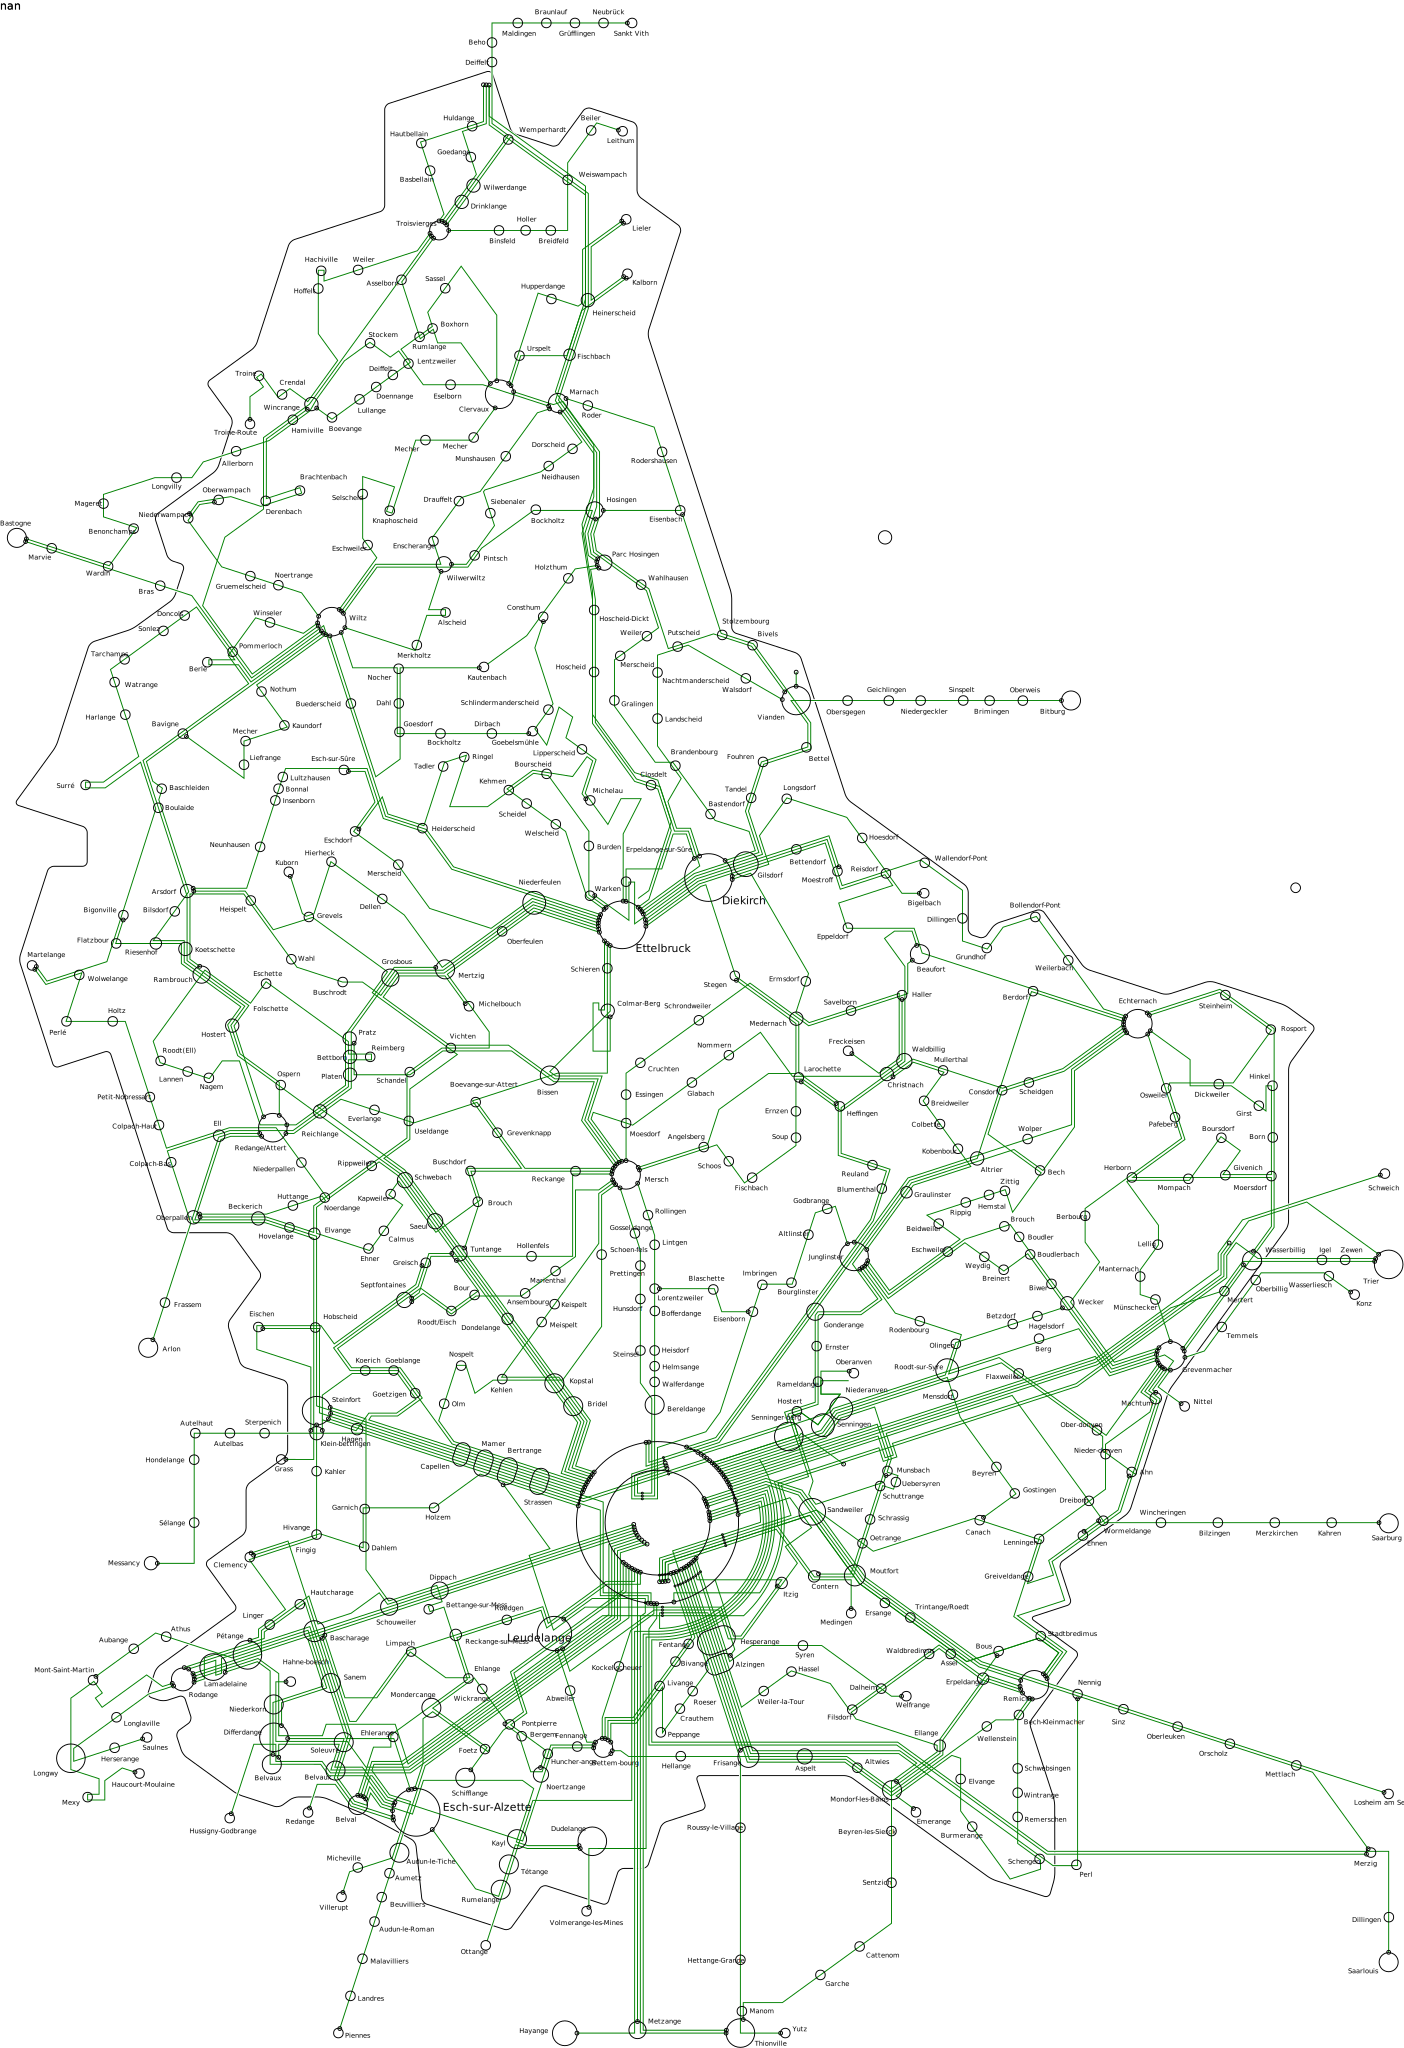

In [32]:
tags = []

def group(*tags, id=None):
    tags = '\n'.join(tags)
    if id:
        return f'<g id="{id}">{tags}</g>'
    return f'<g>{tags}</g>'

def path(d, stroke='black', strokeWidth=1):
    return f'<path d="{d}" style="fill: none; stroke: {stroke}; stroke-width: {strokeWidth}" />'

def ellipse(cx, cy, rx=1, ry=None, stroke='black', fill='none', rotate=0):
    if ry is not None and np.isfinite(ry):
        return f'<ellipse cx="{cx}" cy="{cy}" rx="{rx}" ry="{ry}" style="fill: {fill}; stroke: {stroke};" transform="rotate({rotate})" />'
    return f'<circle cx="{cx}" cy="{cy}" r="{rx}" style="fill: {fill}; stroke: {stroke};" />'

def text(x, y, text, fontSize=8):
    return f'<text x="{x}" y="{y}" style="font-size: 8pt; font-family: sans-serif; font-size: {fontSize};">{text}</text>'

# frontier
tags.append(group(path(frontier['path'].iloc[0]), id='frontier'))

# lines
for kw in ({'stroke': 'white', 'strokeWidth': 3}, {'stroke': 'green', 'strokeWidth': 1}):
    l = (group(path(line.path, **kw), id=f'line-{line.id}') for line in lines.itertuples(index=None))
    tags.append(group(*l, id='lines'))

# stops
s = (group(ellipse(s.cx, s.cy, s.rx, None if s.ry == np.nan else s.ry, rotate=s.rotate) if not pd.isnull(s.rx) else path(s.path)) for s in stops.itertuples())
tags.append(group(*s, id='stops'))

s = (group(text(s.label_x, s.label_y, s.label, fontSize=7 * 1.618 if not pd.isnull(s.rx) and s.rx > 15 else 7)) for s in stops.itertuples())
tags.append(group(*s, id='stop_labels'))

# stations
s = (group(ellipse(s.cx, s.cy, s.rx)) for s in stations.itertuples())
tags.append(group(*s, id='stations'))


svg = '<?xml version="1.0" encoding="UTF-8"?><svg xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink" viewBox="{}">{}</svg>'
svg = svg.format(viewBox, '\n'.join(tags))

SVG(svg)

There remain a few small problems:

 [ ] the paths for stops in Mamer, Bertrange etc. should be absolute coordinates, not relative
 [ ] there are a couple of ellipses, which require translate / rotate
 [ ] there is the weird --Igel code
 [ ] there is the mistery stop in Germany

Create JSON export files

In [37]:
def optional(**kwargs):
    return {k: v for k, v in kwargs.items() if not pd.isnull(v)}

export = {
    'viewBox': viewBox,
    'frontier': frontier['d'].iloc[0],
    'lines': [
        {'id': group, 'd': d}
        for group, d in (
            lines.groupby('id')
            .agg({'path': list})
            .itertuples(name=None, index=True)
        )
    ], 'stops': [
       optional(id=s.id, label=s.label, cx=s.cx, cy=s.cy, r=s.rx, path=s.path, lx=s.label_x, ly=s.label_y)
       for s in stops.itertuples()
    ], 'stations': [
       optional(id=s.id, cx=s.cx, cy=s.cy, r=s.rx, master=s.master)
       for s in stations.itertuples()   
    ]
}
with open('busmap.json', 'w') as f:
    json.dump(export, f)
shutil.copyfile('busmap.json', '../../public/data/publictransport/busmap.json')

'../../public/data/publictransport/busmap.json'

### Tests to address [issue #9](https://github.com/observatoire-mobilite/odm-website/issues/9):

In [13]:
stations

,id,master,cx,cy,rx,class,transform,name
0,2,NaN,1456.882,2038.255,2,cls-13,NaN,Saarlouis
1,7,NaN,1452.022,1870.595,2,cls-13,NaN,Losheim_am_See
2,8,NaN,1448.162,1222.905,2,cls-13,NaN,Schweich
3,9,NaN,1446.752,1587.565,2,cls-13,NaN,Saarburg
4,10,NaN,1446.312,1305.975,2,cls-13,NaN,Trier
...,...,...,...,...,...,...,...,...
415,454,Monterey,668.572,1600.775,2,cls-13,NaN,Badanstalt
416,455,Monterey,667.112,1598.095,2,cls-13,NaN,Badanstalt
417,457,Monterey,666.022,1595.295,2,cls-13,NaN,Badanstalt
418,459,Monterey,665.262,1592.385,2,cls-13,NaN,Badanstalt


In [14]:
[s for s in export['stops'] if s.get('label') == 'Bertrange']

[{'id': 623,
  'label': 'Bertrange',
  'cx': 565.874,
  'cy': 1557.9440745293825,
  'path': 'M 572.27,1553.187 C 570.81,1556.5179999999998 565.954,1558.973 561.511,1557.514 C 557.068,1556.0549999999998 554.612,1551.1989999999998 556.0699999999999,1546.7559999999999 L 559.478,1536.377 C 560.938,1531.934 565.794,1529.479 570.237,1530.9379999999999 C 574.68,1532.397 577.136,1537.253 575.678,1542.8079999999998 L 572.27,1553.1869999999997 L 572.27,1553.187',
  'lx': '532.507',
  'ly': '1514.075'}]

### Exports for data pre-processing

In [15]:
stops[['id', 'label']].to_csv('stop-places.csv', index=None)

In [18]:
stops[stops['label'].isnull()]

,id,cx,cy,rx,ry,path,translate_x,translate_y,rotate,label,label_x,label_y
211,407,689.817,1587.51,85.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
212,408,689.817,1587.51,55.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
stop_labels.query('id==408')

,id,transform,label,name,label_x,label_y


In [42]:
stops[['id', 'label', 'cx', 'cy']].to_csv('stops.csv', index=None)